<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/Memoria_experiment3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aplicamos las técnicas de preprocesamiento que hemos comprobado más efectivas y aplicamos word emmbedding. Al ser el resultado una matriz aplicamos CNN

https://medium.com/@mrunal68/text-sentiments-classification-with-cnn-and-lstm-f92652bc29fd

BN alternatives

https://towardsdatascience.com/an-alternative-to-batch-normalization-2cee9051e8bc

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

from numpy.random import seed
seed(9)

import tensorflow as tf
tf.random.set_seed(9)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re
import string
from collections import Counter

nltk.download("popular")
nltk.download('stopwords')
print(tf.__version__)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [4]:
df = pd.read_csv("gdrive/My Drive/TFG/overviews_final.csv", sep='#',encoding='utf-8', lineterminator='\n')

df['text_array'] = df.overview.str.split(" ")
df['n_words'] = df['text_array'].apply(lambda x: len(x))
df = df.drop(columns=['text_array'])
#df = df[df['n_words']>15]

df.shape

(2043, 10)

In [5]:
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: eval(x))

In [6]:
# Normalización

def normalize(x):
  x = x.lower()
  replacements = (
      ("á", "a"),
      ("é", "e"),
      ("í", "i"),
      ("ó", "o"),
      ("ú", "u"),
      ("ñ", "n")
  )
  for a, b in replacements:
      x = x.replace(a, b)

  x = x.translate(str.maketrans('','',string.punctuation))
  x = x.translate(str.maketrans('','','ªº¡¿'))   
  x = x.replace("  ", " ") 
  return x

# Stop_words

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist()
stop_words = [normalize(word) for word in stop_words]

def delete_stop_words(x):
  words = x.split(' ')
  words = [word for word in words if word not in stop_words]
  x = str(' '.join(words))
  return x

# Steaming

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
  stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
  return " ".join(stemmed_text)

In [7]:
df['overview'] = df['overview'].progress_apply(lambda x: normalize(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [normalize(i) for i in x])

df['overview'] = df['overview'].progress_apply(lambda x: delete_stop_words(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [delete_stop_words(i) for i in x])

df['overview'] = df['overview'].progress_apply(lambda x: stem_sentence(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [112]:
# Get Text augmentation

X = df.drop(columns=['like'])
y = df['like']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=10)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, stratify=y_train, random_state=10) 

X_test = X_test['overview']
y_test = y_test.values

#X_val = X_val['overview']
#y_val = y_val.values

X_train_new = X_train['overview'].copy()
y_train_new = y_train.copy()

for i in range(0, len(X_train)):
  new_series_X = pd.Series(X_train.iloc[i]['new_overviews'])
  X_train_new = X_train_new.append(new_series_X, ignore_index=True)

  y_value = y_train.iloc[i]
  new_series_y = pd.Series([y_value, y_value])
  y_train_new = y_train_new.append(new_series_y, ignore_index=True)

y_train_new = y_train_new.values
y_train = y_train_new

In [113]:
# Parameters
num_words = 6000

Como en la practica lo que hace Keras para calcular el embedding es indexar la matriz de embbedding necesitamos asignar un índice a cada palabra y aplicarlo a los textos, vamos a generar este indice en función de las sinopsis del train.

In [114]:
# https://keras.io/api/preprocessing/text/

#tokenizer = Tokenizer(num_words=num_words, oov_token='OOV') # Mark non vocabulary words with index 1
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_new)
print(X_train_new[0]) 

X_train = tokenizer.texts_to_sequences(X_train_new) 
X_test = tokenizer.texts_to_sequences(X_test)
#X_val = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index for future padding

print(X_train[0]) 
print(vocab_size)

# Max length vector
print(len(max(X_train, key=len)))

print(list(tokenizer.word_index.items())[0:5])

resusit chas gou regres ciud conoc suen realid result viej amig heart brain medic reviv especial lid busc oportun brind termin expi mal deber sacrifici gou encontr pertenec avanz vid atasc jov mostr camin segu deber ayud dilem
[6319, 1674, 4382, 120, 112, 5, 104, 275, 139, 174, 6, 6320, 6321, 348, 1463, 76, 785, 32, 612, 1904, 176, 6024, 477, 98, 3108, 4382, 25, 1069, 1050, 1, 6322, 9, 1202, 105, 411, 98, 28, 1498]
11715
117
[('vid', 1), ('viv', 2), ('henry', 3), ('decid', 4), ('conoc', 5)]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


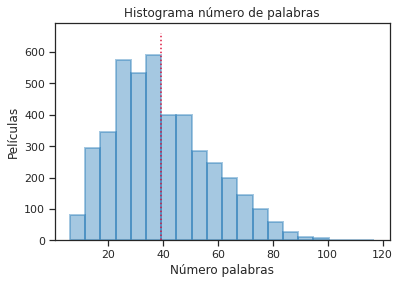

In [115]:
n_words_train = np.array([len(i) for i in X_train])

# seaborn histogram
sns.distplot(n_words_train, hist=True, kde=False, 
             bins=20,
             hist_kws={'edgecolor':'tab:blue', 'linewidth': 2})
# Add labels
plt.title('Histograma número de palabras')
plt.xlabel('Número palabras')
plt.ylabel('Películas')

mean = n_words_train.mean()
plt.vlines(mean, 0, 660, color='crimson', ls=':')

In [116]:
pd.Series(n_words_train).describe()

count    4290.000000
mean       39.282751
std        17.517962
min         6.000000
25%        26.000000
50%        36.000000
75%        51.000000
max       117.000000
dtype: float64

In [117]:
maxlen = 117

X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen, truncating='post')
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen, truncating='post')
#X_val = pad_sequences(X_val, padding='pre', maxlen=maxlen, truncating='post')

X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 6319, 1674, 4382,  120,  112,    5,  104,  275,  139,
        174,    6, 6320, 6321,  348, 1463,   76,  785,   32,  612, 1904,
        176, 6024,  477,   98, 3108, 4382,   25, 1069, 1050,    1, 6322,
          9, 1202,  105,  411,   98,   28, 1498], dtype=int32)

# CNN

In [14]:
embedding_dim = 32

In [19]:
inputs = layers.Input(shape=(maxlen,))

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)(inputs)
x = layers.Dropout(0.35)(x)

# Conv1D + global max pooling
x = layers.Conv1D(32, 5, padding="valid", activation="relu", strides=2)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.35)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

In [20]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 117)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 117, 32)           374880    
_________________________________________________________________
dropout_2 (Dropout)          (None, 117, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 57, 32)            5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0   

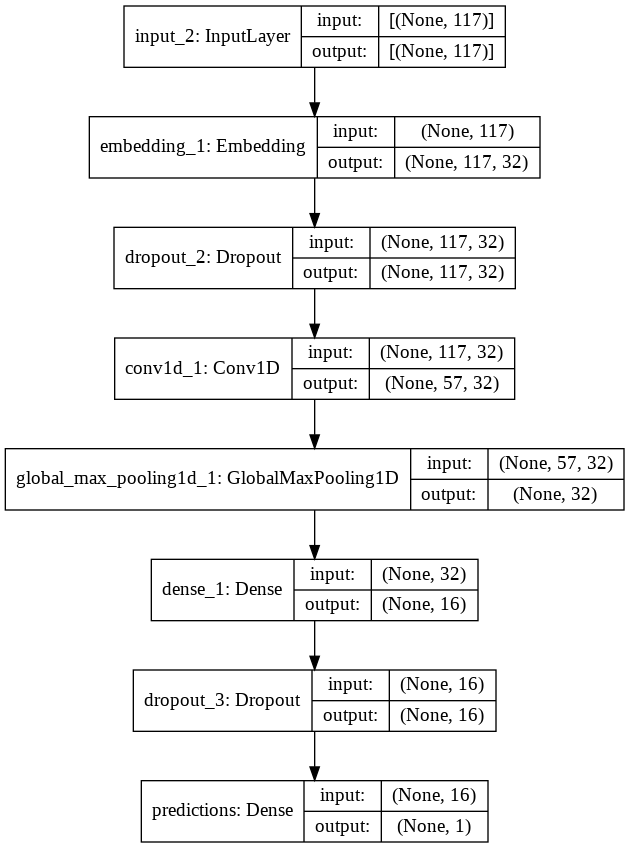

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
epochs = 8
batch_size = 8

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

Epoch 1/8
537/537 [==============================] - 34s 7ms/step - loss: 0.6952 - accuracy: 0.4794 - val_loss: 0.6912 - val_accuracy: 0.5481
Epoch 2/8
537/537 [==============================] - 4s 7ms/step - loss: 0.6905 - accuracy: 0.5317 - val_loss: 0.6895 - val_accuracy: 0.5481
Epoch 3/8
537/537 [==============================] - 3s 6ms/step - loss: 0.6859 - accuracy: 0.5716 - val_loss: 0.6862 - val_accuracy: 0.5481
Epoch 4/8
537/537 [==============================] - 3s 6ms/step - loss: 0.6803 - accuracy: 0.5644 - val_loss: 0.6821 - val_accuracy: 0.5481
Epoch 5/8
537/537 [==============================] - 3s 6ms/step - loss: 0.6669 - accuracy: 0.5990 - val_loss: 0.6720 - val_accuracy: 0.6509
Epoch 6/8
537/537 [==============================] - 4s 7ms/step - loss: 0.6400 - accuracy: 0.7470 - val_loss: 0.6437 - val_accuracy: 0.7423
Epoch 7/8
537/537 [==============================] - 3s 6ms/step - loss: 0.5825 - accuracy: 0.8358 - val_loss: 0.5878 - val_accuracy: 0.7879
Epoch 8/8
53

Text(7.65, 0.85, '0.88')

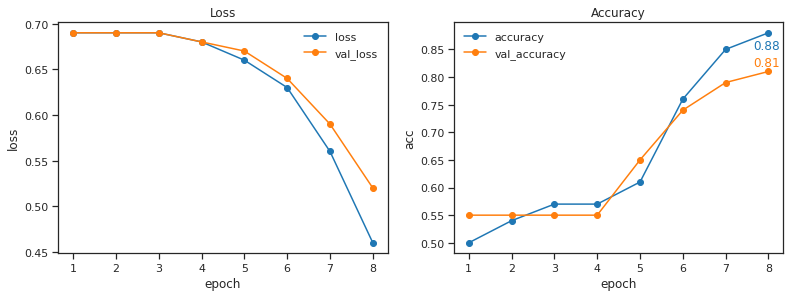

In [24]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1
fit_history = fit_history.round(2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))

# Loss
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', marker='o', ax=ax1)

# Acc
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', marker='o', ax=ax2)

x = fit_history[fit_history['val_accuracy']==fit_history['val_accuracy'].max()]

first_max_acc = fit_history[fit_history['val_accuracy']==fit_history['val_accuracy'].max()].iloc[0]
x = first_max_acc['epoch']
y = first_max_acc['val_accuracy']
z = first_max_acc['accuracy']

ax2.text(x = x - 0.35, # x-coordinate position of data label
         y = y + 0.01, # y-coordinate position of data label, adjusted to be 150 below the data point
         s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
         color = 'tab:orange') # set colour of line
ax2.text(x = x - 0.35, # x-coordinate position of data label
         y = z - 0.03, # y-coordinate position of data label, adjusted to be 150 below the data point
         s = '{:.2f}'.format(z), # data label, formatted to ignore decimals
         color = 'tab:blue') # set colour of line

Con este modelo hemos conseguido reducir la varianza a consta de tener un bias mayor

(NG Book Cap 27)

https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [26]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_true = y_test

print('Acc: ' + str(accuracy_score(y_true, y_pred).round(2)))
print('Precision: ' + str(precision_score(y_true, y_pred).round(2)))
print('Recall: ' + str(recall_score(y_true, y_pred).round(2)))
print('F1: ' + str(f1_score(y_true, y_pred).round(2)))
print('Conf. Matrix: ')
print(confusion_matrix(y_true, y_pred))

Acc: 0.81
Precision: 0.8
Recall: 0.76
F1: 0.78
Conf. Matrix: 
[[284  52]
 [ 67 210]]


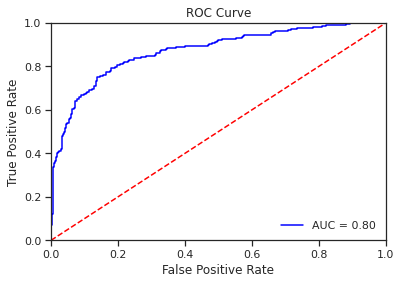

AUC: 0.8017


In [27]:
y_pred_keras = model.predict(X_test).flatten()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_keras)
roc_auc = roc_auc_score(y_true, y_pred)

def plot_roc_curve(fpr,tpr): 
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()   
  
plot_roc_curve(fpr,tpr) 
print('AUC: ' + str(roc_auc.round(4)))

# RNN

In [49]:
inputs = layers.Input(shape=(maxlen,))

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# LSTM
x = layers.LSTM(8)(x)
#x = layers.Dropout(0.3)(x)

# We add a vanilla hidden layer:
x = layers.Dense(4, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

In [50]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 117)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 117, 32)           374880    
_________________________________________________________________
dropout_12 (Dropout)         (None, 117, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
_________________________________________________________________
dropout_13 (Dropout)         (None, 4)                 0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 5   

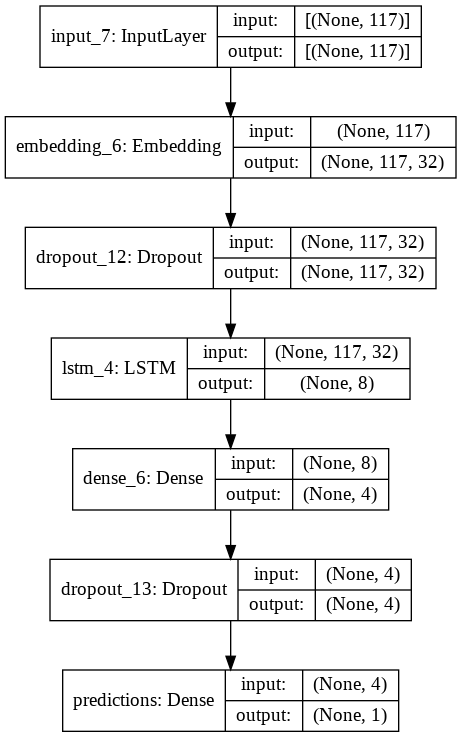

In [51]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [52]:
epochs = 8
batch_size = 8

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

Epoch 1/8
537/537 [==============================] - 7s 10ms/step - loss: 0.6926 - accuracy: 0.5207 - val_loss: 0.6906 - val_accuracy: 0.5856
Epoch 2/8
537/537 [==============================] - 5s 9ms/step - loss: 0.6870 - accuracy: 0.5957 - val_loss: 0.6785 - val_accuracy: 0.6786
Epoch 3/8
537/537 [==============================] - 5s 9ms/step - loss: 0.6548 - accuracy: 0.7006 - val_loss: 0.6027 - val_accuracy: 0.7471
Epoch 4/8
537/537 [==============================] - 5s 9ms/step - loss: 0.5363 - accuracy: 0.7930 - val_loss: 0.5251 - val_accuracy: 0.8124
Epoch 5/8
537/537 [==============================] - 5s 9ms/step - loss: 0.4511 - accuracy: 0.8506 - val_loss: 0.4845 - val_accuracy: 0.8222
Epoch 6/8
537/537 [==============================] - 5s 9ms/step - loss: 0.3860 - accuracy: 0.8637 - val_loss: 0.4510 - val_accuracy: 0.8271
Epoch 7/8
537/537 [==============================] - 5s 9ms/step - loss: 0.3473 - accuracy: 0.8709 - val_loss: 0.4365 - val_accuracy: 0.8206
Epoch 8/8
53

Text(5.65, 0.87, '0.86')

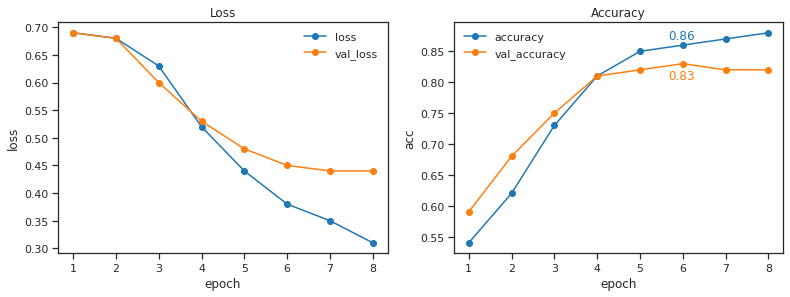

In [58]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1
fit_history = fit_history.round(2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))

# Loss
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', marker='o', ax=ax1)

# Acc
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', marker='o', ax=ax2)

x = fit_history[fit_history['val_accuracy']==fit_history['val_accuracy'].max()]

first_max_acc = fit_history[fit_history['val_accuracy']==fit_history['val_accuracy'].max()].iloc[0]
x = first_max_acc['epoch']
y = first_max_acc['val_accuracy']
z = first_max_acc['accuracy']

ax2.text(x = x - 0.35, # x-coordinate position of data label
         y = y - 0.025, # y-coordinate position of data label, adjusted to be 150 below the data point
         s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
         color = 'tab:orange') # set colour of line
ax2.text(x = x - 0.35, # x-coordinate position of data label
         y = z + 0.01, # y-coordinate position of data label, adjusted to be 150 below the data point
         s = '{:.2f}'.format(z), # data label, formatted to ignore decimals
         color = 'tab:blue') # set colour of line

# CNN + RNN

In [141]:
from tensorflow.keras import regularizers

embedding_dim = 32

In [175]:
inputs = layers.Input(shape=(maxlen,))

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)(inputs)
x = layers.Dropout(0.7)(x)

# Conv1D + max pooling
x = layers.Conv1D(32, 5, padding="same", activation="relu", strides=1, 
                  kernel_regularizer=regularizers.l1_l2())(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=4)(x)
x = layers.Dropout(0.5)(x)

# LSTM
x = layers.LSTM(32, 
                kernel_regularizer=regularizers.l1_l2())(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)


# We add a vanilla hidden layer:
x = layers.Dense(16, activation="relu",
                 kernel_regularizer=regularizers.l1_l2())(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

In [176]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), metrics=['accuracy'])
model.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 117)]             0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 117, 32)           374880    
_________________________________________________________________
dropout_85 (Dropout)         (None, 117, 32)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 117, 32)           5152      
_________________________________________________________________
batch_normalization_66 (Batc (None, 117, 32)           128       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 29, 32)            0         
_________________________________________________________________
dropout_86 (Dropout)         (None, 29, 32)            0  

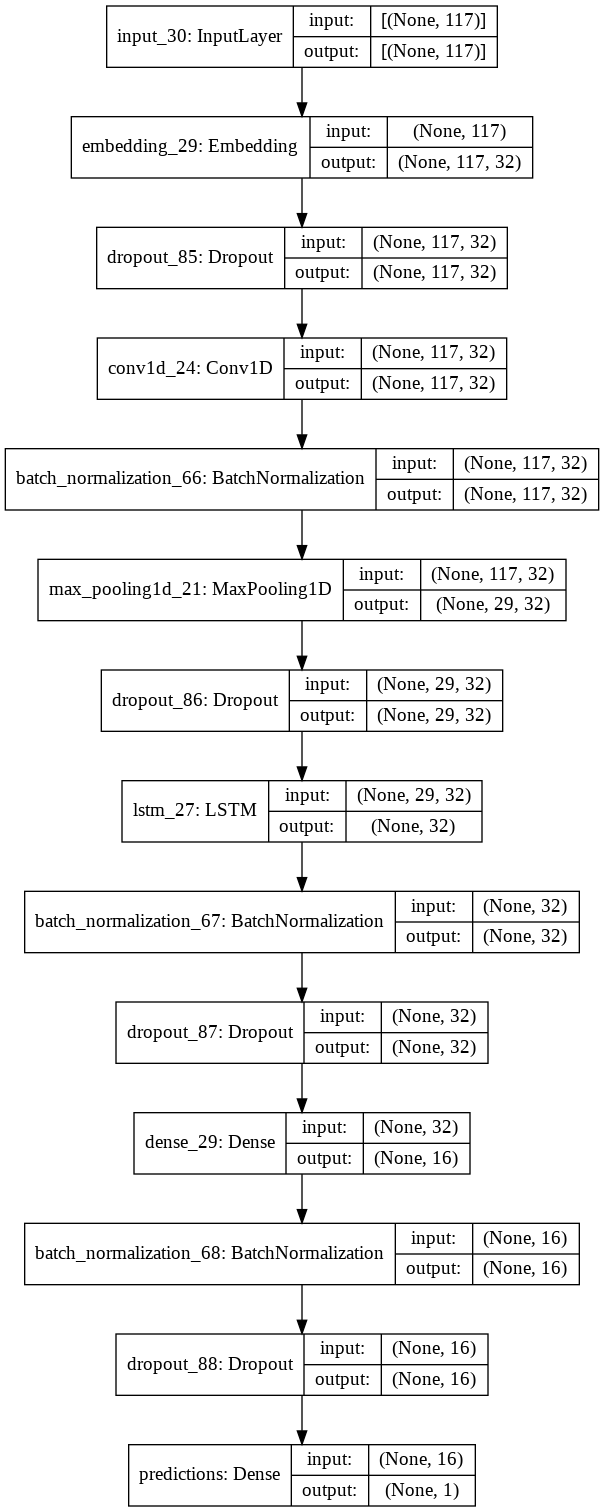

In [177]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [178]:
epochs = 10
batch_size = 8

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

Epoch 1/10
537/537 [==============================] - 8s 11ms/step - loss: 9.6949 - accuracy: 0.4919 - val_loss: 7.7465 - val_accuracy: 0.4943
Epoch 2/10
537/537 [==============================] - 5s 10ms/step - loss: 7.3232 - accuracy: 0.5335 - val_loss: 5.7396 - val_accuracy: 0.5791
Epoch 3/10
537/537 [==============================] - 5s 10ms/step - loss: 5.4615 - accuracy: 0.5094 - val_loss: 4.2461 - val_accuracy: 0.5742
Epoch 4/10
537/537 [==============================] - 5s 10ms/step - loss: 4.0491 - accuracy: 0.5239 - val_loss: 3.2102 - val_accuracy: 0.5628
Epoch 5/10
537/537 [==============================] - 5s 10ms/step - loss: 3.0585 - accuracy: 0.5409 - val_loss: 2.4908 - val_accuracy: 0.5791
Epoch 6/10
537/537 [==============================] - 5s 10ms/step - loss: 2.3819 - accuracy: 0.5520 - val_loss: 1.9663 - val_accuracy: 0.5498
Epoch 7/10
537/537 [==============================] - 5s 10ms/step - loss: 1.8676 - accuracy: 0.6062 - val_loss: 1.6661 - val_accuracy: 0.4780

Text(9.65, 0.83, '0.86')

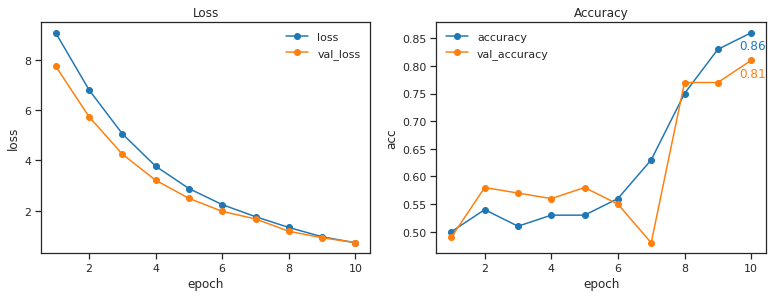

In [183]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1
fit_history = fit_history.round(2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))

# Loss
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', marker='o', ax=ax1)

# Acc
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', marker='o', ax=ax2)

x = fit_history[fit_history['val_accuracy']==fit_history['val_accuracy'].max()]

first_max_acc = fit_history[fit_history['val_accuracy']==fit_history['val_accuracy'].max()].iloc[0]
x = first_max_acc['epoch']
y = first_max_acc['val_accuracy']
z = first_max_acc['accuracy']

ax2.text(x = x - 0.35, # x-coordinate position of data label
         y = y - 0.03, # y-coordinate position of data label, adjusted to be 150 below the data point
         s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
         color = 'tab:orange') # set colour of line
ax2.text(x = x - 0.35, # x-coordinate position of data label
         y = z - 0.03, # y-coordinate position of data label, adjusted to be 150 below the data point
         s = '{:.2f}'.format(z), # data label, formatted to ignore decimals
         color = 'tab:blue') # set colour of line

In [184]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_true = y_test

print('Acc: ' + str(accuracy_score(y_true, y_pred).round(2)))
print('Precision: ' + str(precision_score(y_true, y_pred).round(2)))
print('Recall: ' + str(recall_score(y_true, y_pred).round(2)))
print('F1: ' + str(f1_score(y_true, y_pred).round(2)))
print('Conf. Matrix: ')
print(confusion_matrix(y_true, y_pred))

Acc: 0.81
Precision: 0.79
Recall: 0.79
F1: 0.79
Conf. Matrix: 
[[278  58]
 [ 58 219]]


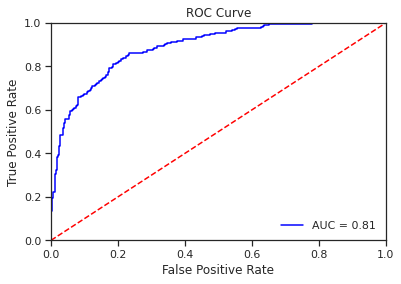

AUC: 0.809


In [187]:
y_pred_keras = model.predict(X_test).flatten()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_keras)
roc_auc = roc_auc_score(y_true, y_pred)

def plot_roc_curve(fpr,tpr): 
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()   
  
plot_roc_curve(fpr,tpr) 
print('AUC: ' + str(roc_auc.round(4)))